## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

In [5]:
test_img.shape

(28000, 28, 28)

## Визуализируем исходные данные

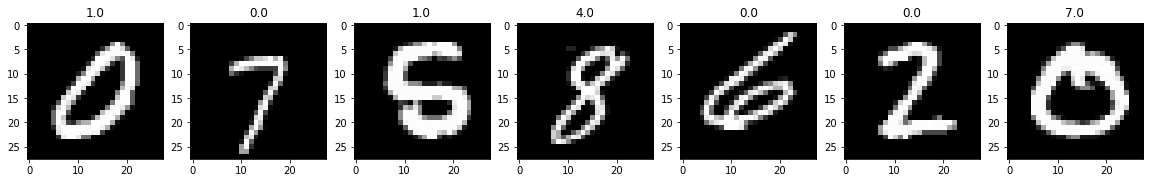

In [6]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[17:24], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
train_sobel_x [10].shape

(28, 28)

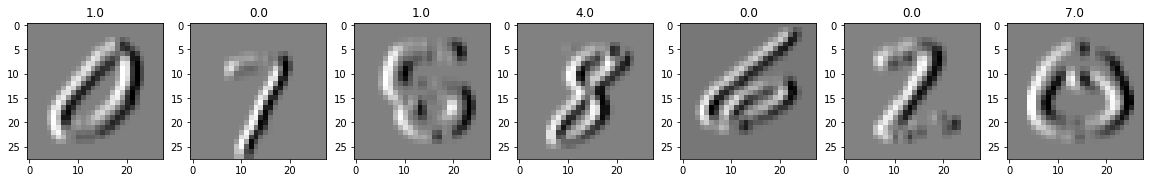

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_sobel_x[17:24], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [10]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [11]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [12]:
train_g[10].shape

(28, 28)

In [13]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

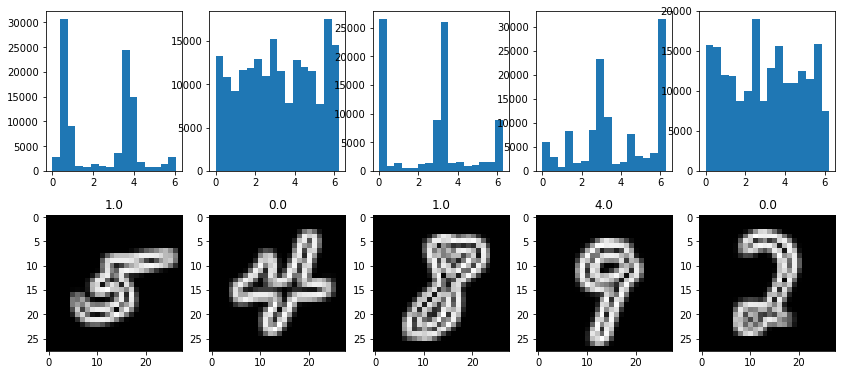

In [14]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[80:85], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [72]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [73]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Разобьем каждый объект на 4 части и подсчитаем градиенты для каждой части

In [15]:
BINS=32
n_row=14

In [16]:
# разделение на квадрат
train_hist_4 = np.zeros((len(train_img), BINS*4))
for i in range(len(train_img)):
    hist0, br0 = np.histogram(train_theta[i][:n_row,:n_row],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:n_row,:n_row])
    hist1, br1 = np.histogram(train_theta[i][:n_row,n_row+1:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:n_row,n_row+1:])
    hist2, br2 = np.histogram(train_theta[i][n_row+1:,:n_row],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][n_row+1:,:n_row])
    hist3, br3 = np.histogram(train_theta[i][n_row+1:,n_row+1:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][n_row+1:,n_row+1:])
    train_hist_4[i] =np.concatenate((hist0,hist1,hist2,hist3),axis=0)
train_hist_4.shape    

(42000, 128)

In [17]:
# разделение на вертикальные части всего 28/4
train_hist_vr = np.zeros((len(train_img), BINS*4))
for i in range(len(train_img)):
    hist0, br0 = np.histogram(train_theta[i][:,:7],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:,:7])
    hist1, br1 = np.histogram(train_theta[i][:,8:14],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:,8:14])
    hist2, br2 = np.histogram(train_theta[i][:,15:21],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:,15:21])
    hist3, br3 = np.histogram(train_theta[i][:22:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:22:])
    train_hist_vr[i] =np.concatenate((hist0,hist1,hist2,hist3),axis=0)
hist3.shape    

(32,)

In [18]:
# разделение на горизонтальные части всего 28/4
train_hist_gr = np.zeros((len(train_img), BINS*4))
for i in range(len(train_img)):
    hist0, br0 = np.histogram(train_theta[i][:7,:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][:7,:])
    hist1, br1 = np.histogram(train_theta[i][8:14,:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][8:14,:])
    hist2, br2 = np.histogram(train_theta[i][15:21,:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][15:21,:])
    hist3, br3 = np.histogram(train_theta[i][22:,:],bins=BINS,range=(0., 2. * np.pi),weights=train_g[i][22:,:])
    train_hist_gr[i] =np.concatenate((hist0,hist1,hist2,hist3),axis=0)
hist3.shape    

(32,)

In [19]:
# попробуем обьеденить горизонтальное и вертикальное
train_hist=np.concatenate((train_hist_4,train_hist_gr),axis=1)
train_hist.shape

(42000, 256)

In [20]:
# разделение на квадрат
train_hist_4 = np.zeros((len(test_img), BINS*4))
for i in range(len(test_img)):
    hist0, br0 = np.histogram(test_theta[i][:n_row,:n_row],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][:n_row,:n_row])
    hist1, br1 = np.histogram(test_theta[i][:n_row,n_row+1:],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][:n_row,n_row+1:])
    hist2, br2 = np.histogram(test_theta[i][n_row+1:,:n_row],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][n_row+1:,:n_row])
    hist3, br3 = np.histogram(test_theta[i][n_row+1:,n_row+1:],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][n_row+1:,n_row+1:])
    train_hist_4[i] =np.concatenate((hist0,hist1,hist2,hist3),axis=0)

In [21]:
# разделение на горизонтальные части всего 28/4
train_hist_gr = np.zeros((len(test_img), BINS*4))
for i in range(len(test_img)):
    hist0, br0 = np.histogram(test_theta[i][:7,:],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][:7,:])
    hist1, br1 = np.histogram(test_theta[i][8:14,:],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][8:14,:])
    hist2, br2 = np.histogram(test_theta[i][15:21,:],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][15:21,:])
    hist3, br3 = np.histogram(test_theta[i][22:,:],bins=BINS,range=(0., 2. * np.pi),weights=test_g[i][22:,:])
    train_hist_gr[i] =np.concatenate((hist0,hist1,hist2,hist3),axis=0)

In [22]:
test_hist=np.concatenate((train_hist_4,train_hist_gr),axis=1)
test_hist.shape

(28000, 256)

## Scale Invariant Feature Transform Scale // УХУДШИЛО!!

In [ ]:
N = len(train_hist[80])
x = range(N)
width = 1/1.5
plt.bar(x, train_hist[80], width, color="blue")

<Container object of 256 artists>

In [81]:
# маскимальное значение должно быть в нулевой ячеке
def max_first (train_hist): 
    for i in range(len(train_hist)):
        max_id=train_hist[i].argmax()
        if max_id>0:
            x1,x2=np.split(train_hist[i],[max_id])
            if len(x1)<=2:
                train_hist[i]=np.concatenate((x2,x1),axis=0)
    return train_hist

In [82]:
train_hist= max_first(train_hist)
test_hist= max_first(test_hist)

<Container object of 8 artists>

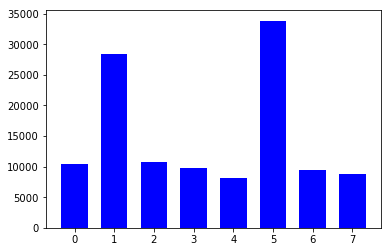

In [83]:
width = 1/1.5
plt.bar(x, train_hist[80], width, color="blue")

## Нормируем вектор гистограммы

In [55]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [56]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [70]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Вычисляем центроиды каждого из 10 классов

In [25]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [33]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

In [57]:
for i in range(10):
    centroids[i] = np.mean(train_hist[train_label == i], axis=0)

## Находим ближайший центройд для валидации

In [34]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

## KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [38]:
%%time
xgb_scoring={}
for n_tree in [5, 10,15,20,25]:
    neigh = KNeighborsClassifier(n_neighbors=n_tree, n_jobs=-1)
    scores = cross_val_score(neigh, x_train, y_train, cv=4)
    xgb_scoring[n_tree]=scores.mean()

Wall time: 16min 18s


In [39]:
xgb_scoring 

{5: 0.94800622864239137,
 10: 0.94755990988675531,
 15: 0.94547670398045069,
 20: 0.94392890057265821,
 25: 0.94205376230505311}

## XGBOOST и прочие радости

In [61]:
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
%%time
# Random Forest!
xgb_scoring={}
for n_tree in [100,120,150,170]:
    estimator=RandomForestClassifier(n_estimators=n_tree,warm_start=True, n_jobs=-1)
    scores = cross_val_score(estimator, x_train, y_train, cv=4)
    xgb_scoring[n_tree]=scores.mean()
xgb_scoring    

In [84]:
%%time
#великий и ужасный XGBoost
xgb_scoring={}
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
for n_tree in [200]:
    estimator=xgb.XGBClassifier(n_estimators=n_tree, silent=1, nthread=-1)
    scores = cross_val_score(estimator, x_train, y_train, cv=4)
    xgb_scoring[n_tree]=scores.mean()
xgb_scoring  

Wall time: 8min 52s


In [85]:
#100 0.96029 
#50 0.940
#120 0.9641
#150 0.9684
#170 0.97014
#200 
xgb_scoring


{170: 0.9701488463571184}

## Обучим и предскажем

In [34]:
estimator=RandomForestClassifier(n_estimators=120,warm_start=True, n_jobs=-1)
estimator.fit(train_hist, train_label)
pred_test=estimator.predict(test_hist)

## Оцениваем качество решение на валидационной выборке

In [35]:
#Accuracy: 16 bins 0.427023809524
#Accuracy: 8 bins 0.445119047619
#Accuracy: 8 bins 0.3025 + центрирование
#Accuracy 8 bins + 4 max сдвиг 0.3170
#Accuracy 8 bins + 2 max сдвиг  0.3469
# с разделением на 4 квадрата
#Accuracy: 16 bins 0.8297
#Accuracy: 8 bins 0.7913  хуже
#Accuracy: 32 bins 0.8311
# с разделением на 4 по вертикали
#Accuracy: 0.6192
# с разделением на 4 по горизонтали
#Accuracy: 0.77880952381  отлично лучше разделяет 8 от 9
# обьеденим горизонтальное и вртикальное разделение Accuracy: 0.7267
# объеденим  квадраты и горизонтальное Accuracy: 0.8579 ========== лучший вариант!!для центройда на валидации
#++++++++++++++ KNN
#10: 0.9475 +
#5: 0.9480
#++++++++++++++ RandomForestClassifier
#100: 0.9605 
#150: 0.9625  120
#200: 0.9631
#300: 0.9638
#++++++++++++++ XGBoost
#100 0.96029
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.857976190476


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

In [203]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[558  28  46   2  70  44  48   0  19   1]
 [  2 694   1   0  59   0 108  28  14   3]
 [  4   2 404 111  11 130  25  41  43  75]
 [  0   0  76 625   5 117   1   5  56  52]
 [ 16 104  15   4 448   3 145  49  17  38]
 [  0   1  40  50   3 542   4   5  54   3]
 [ 73  50  17   1  16  31 531   1  65   0]
 [  3  54  56  16  51  50 101 501  11  50]
 [  8  18  34  11  29  68 104   5 527  31]
 [  5  57  80  35  61  17  99  87  25 372]]


## Предсказания на тестовыйх данных

In [58]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

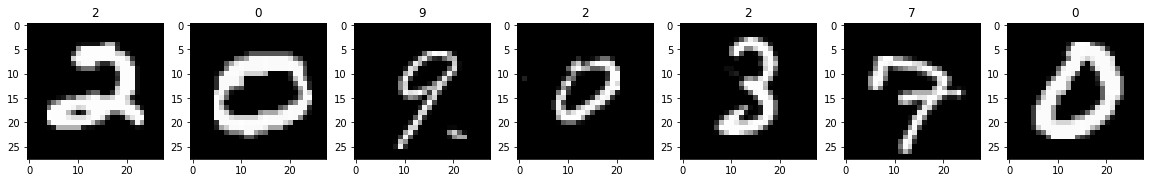

In [59]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i-1]);

## Готовим файл для отправки

In [60]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%i\n' % (i, p))